In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)


4.5.1


***
#### Part I: Video stabilization 



In [5]:
cap = cv2.VideoCapture('P1_roundabout.mp4')

# params for corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.001,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for optical flow
lk_params = dict( winSize  = (50,50), 
                  maxLevel = 5, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


N = 150 # borders size

# Take first frame and find corners in it
ret, F0 = cap.read()
F0 = cv2.copyMakeBorder(F0, N, N, N, N, cv2.BORDER_CONSTANT)
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)

h,w = F0_gray.shape

FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') # or just copy it from the original video
out = cv2.VideoWriter('P1_roundabout_stabilized.mp4',fourcc, FPS, (1280,720)) # (W,H) should be integers

center_coordinates = (int(F0.shape[1]/2),int(F0.shape[0]/2)-20)
radius = 275
color = (255, 0, 0)
thickness = -1
black = np.zeros(F0_gray.shape[:2], dtype="uint8")
circle_mask  = cv2.circle(black, center_coordinates, radius, color, -1)
mid_circle = cv2.bitwise_and(circle_mask, circle_mask, mask = circle_mask)

pts0 = cv2.goodFeaturesToTrack(mid_circle, mask = None, **feature_params)
pts_ref = pts0.copy()





while True:
    ret, F1 = cap.read() # read next frame
    if ret==True:
        F1 = cv2.copyMakeBorder(F1, N, N, N, N, cv2.BORDER_CONSTANT)
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
        
        # delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        pts_ref = pts_ref[status[:,0]==1]
       
        # find homogrpahy and warp perspective
        H,_ = cv2.findHomography(pts1, pts_ref, cv2.RANSAC,35.0)
        F1_warp = cv2.warpPerspective(F1, H, (w,h))
  
        # update the previous frame and previous points
        F0_gray = F1_gray
        pts0 = pts1
        
        # visualize and save result
        resized = cv2.resize(F1_warp, (1280,720), interpolation = cv2.INTER_AREA)
        cv2.imshow('WINDOW_NAME', resized)
        out.write(resized)
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

cap.release() 
out.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

In [6]:
# cut the frame and focousing on the square
def circle_frame(frame):
    blank = np.zeros(frame.shape[:2],dtype="uint8")
    mask = cv2.circle(blank,(frame.shape[1]//2+8,frame.shape[0]//2-8),285,230,-1)
    masked = cv2.bitwise_and(frame,frame,mask=mask)  

    return masked

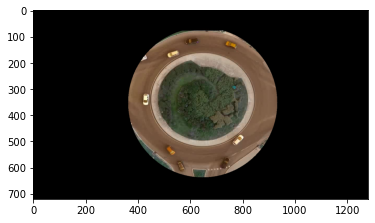

In [7]:
#just to demonstrate
cap = cv2.VideoCapture('P1_roundabout_stabilized.mp4')
ret, F0 = cap.read()
circle = circle_frame(F0)

plt.imshow(circle,cmap="gray")
plt.show()

In [8]:
#Car object for the cars list
class Car:
    def __init__(self,id_num, pts,color):
        self.id_num = id_num
        self.pts = pts
        self.color = color

In [9]:


feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.0001,
                       minDistance = 30,
                       blockSize = 3 )

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))



cap = cv2.VideoCapture('P1_roundabout_stabilized.mp4')
frame_width = int( cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height =int( cap.get( cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
FPS = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter("final.mp4", fourcc,FPS, (1280,760))

cars_list = []
car_counter = 1
car_out_frame = 0


#Preprocess for the first frame to find the countors

ret, frame1 = cap.read()
ret, frame2 = cap.read()
frame1 = circle_frame(frame1)
frame2 = circle_frame(frame2)


diff = cv2.absdiff(frame1, frame2)
gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 7)
blur = cv2.dilate(blur, None, iterations=1)

_, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
dilated = cv2.dilate(thresh, None, iterations=6)
edges = cv2.Canny(blur,100,200)
edges = cv2.dilate(edges, None, iterations=3)
contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# find countors from the first frame
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    if cv2.contourArea(contour) < 4000 and cv2.contourArea(contour)>400 :
        car_ctr = np.zeros_like(gray)
        car_ctr[y+h//2-2:y+h//2+2,x+w//2-2:x+w//2+2] = gray[y+h//2-2:y+h//2+2,x+w//2-2:x+w//2+2]

        pts0 = cv2.goodFeaturesToTrack(car_ctr, mask = None, **feature_params)
#crate a new random color and push all data to the cars list
        car_color = np.random.random(size=3) * 256
        cars_list.append(Car(car_counter,pts0,car_color))
        car_counter+=1


#prepare the next frame  
ret, frame1 = cap.read()
frame1_final = frame1.copy()
ret, frame2 = cap.read()
frame1 = circle_frame(frame1)
frame2 = circle_frame(frame2)
frame1_gray = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

index = 0
while cap.isOpened():
    if ret==True:
        
        diff = cv2.absdiff(frame1, frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        blur = cv2.dilate(blur, None, iterations=1)

        _, thresh = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, None, iterations=6)

#frame1_masked is a mask for old contours
        frame1_masked = dilated.copy()

#Loop all the cars from the list and doing opticalFlow for each contour(car)
#finding the median and draw a circle to hide it in the next frame 
        for car in cars_list:
            if car.pts is not None:
                pts1, status, err = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, car.pts, None, **lk_params)
                if pts1 is not None:
                    pts1 = pts1[status[:,0]==1]
                    car.pts = pts1.copy()
                    sum_x = 0
                    sum_y=0
                    sum_of_val = 0
                    for p1 in pts1:
                        x1,y1 = p1.squeeze().astype(np.int)
                        sum_x += x1
                        sum_y += y1
                        sum_of_val+=1
                    if sum_x>5 :
                        meanx = int(sum_x//sum_of_val)
                        meany = int(sum_y//sum_of_val)
#cheack if the contour is out of the frame
#if the car is out of the frame --> the car will be removed from the list
                        if( frame1_gray[meany,meanx-10]==0 or frame1_gray[meany+5,meanx]==0 or frame1_gray[meany,meanx+6]==0):
                            cars_list.remove(car)
                            car_out_frame+=1
                        else:
#preprocess for the visual text
                            car_id_text = str("Car id: " + str(car.id_num))
                            car_xy_text = str("x: " + str(meanx) + " y: " + str(meany))
                            num_of_cars_text = str(car_counter)+ " Cars detected"
                            car_out_frame_text = str(car_out_frame) + " Cars out of the frame"
                            
                            frame1_masked = cv2.circle(frame1_masked,(meanx,meany),50,(0,0,0),-1) # new points
#draw the text on the final image   

                            frame1 = cv2.putText(frame1, str(car.id_num), (meanx,meany), cv2.FONT_HERSHEY_SIMPLEX,  
                                    1, (255, 0, 0) , 2, cv2.LINE_AA)
    
                            frame1_final = cv2.putText(frame1_final, car_id_text, (meanx,meany), cv2.FONT_HERSHEY_SIMPLEX,  
                                    0.5, car.color, 2, cv2.LINE_AA)
                            
                            frame1_final = cv2.putText(frame1_final, car_xy_text, (meanx,meany+25), cv2.FONT_HERSHEY_SIMPLEX,  
                                    0.5, car.color, 2, cv2.LINE_AA)
                            
                            frame1_final = cv2.putText(frame1_final, num_of_cars_text, (20,30), cv2.FONT_HERSHEY_SIMPLEX,  
                                    0.7, (243,107,148), 1, cv2.LINE_AA)
                            
                            frame1_final = cv2.putText(frame1_final, car_out_frame_text, (20,60), cv2.FONT_HERSHEY_SIMPLEX,  
                                    0.7, (243,107,148), 1, cv2.LINE_AA)
                            
                            


    
        frame1_masked = cv2.dilate(frame1_masked, None, iterations=5)
        contours, _ = cv2.findContours(frame1_masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        index+=1
        
#Search for new cars every 10 frames
        if(index%10==0):
            for contour in contours:
                (x, y, w, h) = cv2.boundingRect(contour)
                if cv2.contourArea(contour) < 3700 and cv2.contourArea(contour)>2000:

                    car_ctr = np.zeros_like(gray)
                    car_ctr[y+h//2-2:y+h//2+2,x+w//2-2:x+w//2+2]   =  gray[y+h//2-2:y+h//2+2,x+w//2-2:x+w//2+2]
                    pts0 = cv2.goodFeaturesToTrack(car_ctr, mask = None, **feature_params)
                    
#crate a new random color and push all data to the cars list
                    car_color = np.random.random(size=3) * 256
                    cars_list.append(Car(car_counter,pts0,car_color))
                    car_counter+=1

           

        frame1_final = cv2.resize(frame1_final, (1280,760))
        out.write(frame1_final)
        cv2.imshow("dilated", dilated)
        cv2.imshow("frame1_final", frame1_final)
        
        frame1 = frame2.copy()
        frame1_gray = frame2_gray
        ret, frame2 = cap.read()
        if ret==True:
            frame1_final = frame2.copy()
            frame2 = circle_frame(frame2)
            frame2_gray = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    else:
        break
    if cv2.waitKey(40) == 27:
        break

cv2.destroyAllWindows()
cap.release()
out.release()